# ofdm_channel
## 介绍
- Layer for implementing an ideal OFDM channel response, i.e., single-tap
channel response in the frequency domain 
- 用于实现理想的OFDM信道响应的层，即单输出频域的信道响应

In [20]:
import tensorflow as tf
import sionna as sn
from tensorflow.python.keras.layers import Layer
from sionna.channel import GenerateOFDMChannel, ApplyOFDMChannel
from sionna.channel import RayleighBlockFading
from sionna.ofdm import ResourceGrid


## OFDMChannel
`OFDMChannel(channel_model, resource_grid, add_awgn=True, normalize_channel=False, return_channel=False, dtype=tf.complex64, **kwargs)`

Generate channel frequency responses and apply them to channel inputs assuming an OFDM waveform with no ICI nor ISI.

生成信道频率响应并将其应用于信道输入,假设OFDM波形没有ICI和ISI。

在通信系统中，ICI（Inter-Carrier Interference，载波间干扰）和ISI（Inter-Symbol Interference，符号间干扰）是两种常见的干扰类型：

1. **ICI（Inter-Carrier Interference）：** ICI 是指在正交频分复用（OFDM）系统中，由于信号在频率上的偏移导致的干扰现象。在 OFDM 系统中，不同子载波之间是正交的，但是如果存在频率偏移，就会导致部分信号波形重叠，产生干扰。ICI 可能由于载波频偏、时钟偏移或多径效应等原因引起。

2. **ISI（Inter-Symbol Interference）：** ISI 是指在数字通信系统中，由于相邻符号之间的信号波形重叠而引起的干扰现象。当信号传输经过信道时，信号波形会受到信道响应的影响，导致相邻符号之间的能量相互干扰，使得接收端无法正确解码。

在上文中提到的场景中，假设了不存在 ICI 和 ISI，意味着在生成和应用频率响应时，忽略了这两种干扰，即假设了信道的频率响应是线性的且不会导致符号之间的干扰。

This class inherits from the Keras `Layer` class and can be used as layer in a Keras model.

这个类继承自Keras的“Layer”类，可以在Keras模型中作为层使用。

For each OFDM symbol s and subcarrier n, the channel output is computed as follows:

对于每个OFDM符号s和子载波n，信道输出计算如下:


$$
y_{s,n} = \widehat{h}_{s, n} x_{s,n} + w_{s,n}
$$

where $y_{s,n}$ is the channel output computed by this layer,
$\widehat{h}_{s, n}$ the frequency channel response,
$x_{s,n}$ the channel input $x$, and $w_{s,n}$ the additive noise.



For multiple-input multiple-output (MIMO) links, the channel output is computed for each antenna
of each receiver and by summing over all the antennas of all transmitters.

The channel frequency response for the $s^{th}$ OFDM symbol and
$n^{th}$ subcarrier is computed from a given channel impulse response
$(a_{m}(t), \tau_{m}), 0 \leq m \leq M-1$ generated by the `channel_model``
as follows:

$$
    \widehat{h}_{s, n} = \sum_{m=0}^{M-1} a_{m}(s) e^{-j2\pi n \Delta_f \tau_{m}}
$$
where $\Delta_f$ is the subcarrier spacing, and $s$ is used as time
step to indicate that the channel impulse response can change from one OFDM symbol to the
next in the event of mobility, even if it is assumed static over the duration
of an OFDM symbol.

## Parameters
----------
**channel_model** : :class: `~sionna.channel.ChannelModel` object

An instance of a :class:`~sionna.channel.ChannelModel` object, such as
:class:`~sionna.channel.RayleighBlockFading` or
:class:`~sionna.channel.tr38901.UMi`.

**resource_grid** : :class:`~sionna.ofdm.ResourceGrid`

    Resource grid

**add_awgn** : bool

If set to `False`, no white Gaussian noise is added.
Defaults to `True`.

**normalize_channel** : bool

If set to `True`, the channel is normalized over the resource grid
to ensure unit average energy per resource element. Defaults to `False`.

**return_channel** : bool

If set to `True`, the channel response is returned in addition to the
channel output. Defaults to `False`.

**dtype : tf.DType**
Complex datatype to use for internal processing and output.
Defaults to tf.complex64.

## Input
-----

(x, no) or x:
    Tuple or Tensor:

**x** :  [batch size, num_tx, num_tx_ant, num_ofdm_symbols, fft_size], tf.complex

- Channel inputs

**no** : Scalar or Tensor, tf.float
- Scalar or tensor whose shape can be broadcast to the shape of the
channel outputs:[batch size, num_rx, num_rx_ant, num_ofdm_symbols, fft_size].

- Only required if ``add_awgn`` is set to `True`.

- The noise power ``no`` is per complex dimension. 

- If ``no`` is a scalar,
noise of the same variance will be added to the outputs.

- If ``no`` is a tensor, it must have a shape that can be broadcast to
the shape of the channel outputs.This allows, e.g., adding noise of
different variance to each example in a batch.
- If ``no`` has a lower rank than the channel outputs, then ``no`` will be broadcast to the
shape of the channel outputs by adding dummy dimensions after the last
axis.

Output
-------
**y** : [batch size, num_rx, num_rx_ant, num_ofdm_symbols, fft_size], tf.complex
- Channel outputs

**h_freq** : [batch size, num_rx, num_rx_ant, num_tx, num_tx_ant, num_ofdm_symbols, fft_size], tf.complex
- (Optional) Channel frequency responses. 
- Returned only if
``return_channel`` is set to `True`.

# class ofdmchannel



In [21]:
class OFDMChannel(Layer):
    def __init__(self, channel_model, resource_grid, add_awgn=True,
                normalize_channel=False, return_channel=False,
                dtype=tf.complex64, **kwargs):
        super().__init__(trainable=False, dtype=dtype, **kwargs)

        self._cir_sampler = channel_model
        self._rg = resource_grid
        self._add_awgn = add_awgn
        self._normalize_channel = normalize_channel
        self._return_channel = return_channel

    def build(self, input_shape): #pylint: disable=unused-argument

        self._generate_channel = GenerateOFDMChannel(self._cir_sampler,
                                                     self._rg,
                                                     self._normalize_channel,
                                                     tf.as_dtype(self.dtype))
        self._apply_channel = ApplyOFDMChannel( self._add_awgn,
                                                tf.as_dtype(self.dtype))

    def call(self, inputs):

        if self._add_awgn:
            x, no = inputs
        else:
            x = inputs

        h_freq = self._generate_channel(tf.shape(x)[0])
        if self._add_awgn:
            y = self._apply_channel([x, h_freq, no])
        else:
            y = self._apply_channel([x, h_freq])

        if self._return_channel:
            return y, h_freq
        else:
            return y

这段代码定义了一个名为`OFDMChannel`的自定义层，用于模拟OFDM系统中的信道效应。下面是对代码的分析和如何使用的说明：

1. `__init__` 方法：初始化 `OFDMChannel` 类，设置了几个参数：
   - `channel_model`：信道模型，用于生成信道脉冲响应。
   - `resource_grid`：资源网格，描述了OFDM系统的参数。
   - `add_awgn`：是否添加加性高斯白噪声。
   - `normalize_channel`：是否对信道进行归一化。
   - `return_channel`：是否返回信道响应。
   - `dtype`：数据类型，默认为 `tf.complex64`。

2. `build` 方法：构建层，设置了两个子模块：
   - `_generate_channel`：生成信道，调用 `GenerateOFDMChannel` 类。
   - `_apply_channel`：应用信道效应，调用 `ApplyOFDMChannel` 类。

3. `call` 方法：执行层的前向传播操作。
   - 如果添加了高斯白噪声，则将输入拆分为信号 `x` 和噪声 `no`。
   - 使用 `_generate_channel` 生成频域信道响应 `h_freq`。
   - 如果添加了高斯白噪声，则调用 `_apply_channel` 应用信道效应并添加噪声。
   - 如果设置了 `return_channel`，则返回信道响应和输出信号；否则，只返回输出信号。


```
super().__init__(trainable=False, dtype=dtype, **kwargs)   
```
这行代码是在 `OFDMChannel` 类的构造函数中调用父类的构造函数 `__init__()`。具体解析如下：

- `super()` 函数：用于调用父类的方法。在这里，`super().__init__()` 调用了父类 `Layer` 的构造函数。
- `__init__(trainable=False, dtype=dtype, **kwargs)`：这是调用父类构造函数的参数列表。
  - `trainable=False`：指定了这个自定义层不可训练，即在模型的训练过程中不会更新该层的参数。
  - `dtype=dtype`：指定了数据类型，默认为 `dtype` 参数指定的类型，通常是 `tf.complex64`。
  - `**kwargs`：表示可接受任意数量的关键字参数，并将它们传递给父类的构造函数。

这行代码的作用是在初始化 `OFDMChannel` 类时，调用父类 `Layer` 的构造函数，并指定了一些参数，如不可训练和数据类型。

# 应用

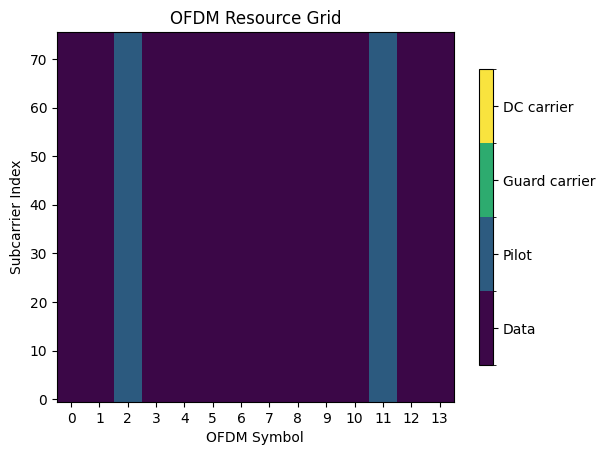

In [23]:
# 定义信道模型和资源网格
channel_model = sn.channel.RayleighBlockFading(num_rx = 1,
                               num_rx_ant = 32,
                               num_tx = 4,
                               num_tx_ant = 2)
# 定义参数
num_ofdm_symbols = 14
fft_size = 76
subcarrier_spacing = 30e3
num_tx = 1
num_streams_per_tx = 1
cyclic_prefix_length = 6
pilot_pattern = "kronecker"
pilot_ofdm_symbol_indices = [2, 11]

# 创建 ResourceGrid 实例
resource_grid = sn.ofdm.ResourceGrid(num_ofdm_symbols=num_ofdm_symbols,
                                      fft_size=fft_size,
                                      subcarrier_spacing=subcarrier_spacing,
                                      num_tx=num_tx,
                                      num_streams_per_tx=num_streams_per_tx,
                                      cyclic_prefix_length=cyclic_prefix_length,
                                      pilot_pattern=pilot_pattern,
                                      pilot_ofdm_symbol_indices=pilot_ofdm_symbol_indices)

# 展示 ResourceGrid
resource_grid.show()


# 创建 OFDMChannel 层
ofdm_channel = OFDMChannel(channel_model, resource_grid,return_channel=True)

# 输入信号和噪声（可选）
# x is the channel input
# no is the noise variance
# x = ...
# no = ...

# 获取输出信号和信道响应
# y, h_freq = ofdm_channel([x, no])  # 如果需要信道响应，设置 return_channel=True
